In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import glob
import os

# Compare half-hour aggregation to daily

In [36]:
# read files
files = glob.glob("data/Bnei_brak_check/*.csv")
df_list = [pd.read_csv(file) for file in files]
bnei_brak = pd.concat(df_list, ignore_index = True)

In [37]:
# correct datetime
bnei_brak['corrected_datetime'] = bnei_brak['date_time'].apply(fix_24_hour_format)
bnei_brak['datetime'] = pd.to_datetime(bnei_brak['corrected_datetime'], format='%H:%M %d/%m/%Y')
bnei_brak.drop(["date_time", "corrected_datetime"], axis=1, inplace=True)
bnei_brak = bnei_brak.rename(columns = {'Bnei_brak_highway4':'CO'})

In [39]:
# define na and correct negative (out of calibration) values
bnei_brak["CO"] = bnei_brak["CO"].apply(pd.to_numeric, errors='coerce')
bnei_brak["CO"] = bnei_brak["CO"].map(lambda x: 0 if x<0 else x) 

In [40]:
daily = bnei_brak.groupby([bnei_brak["datetime"].dt.year.rename("Year"), 
                   bnei_brak["datetime"].dt.month.rename("Month"), 
                   bnei_brak["datetime"].dt.day.rename("Day")])["CO"].mean().reset_index()
daily["date_time"] = pd.to_datetime(daily[["Year","Month", "Day"]])
daily.drop(["Year","Month", "Day"], axis=1, inplace=True)

In [29]:
daily_co = pd.read_csv('data/co_daily_clean.csv')
daily_co['date'] = pd.to_datetime(daily_co['date'], format = "%d/%m/%Y")

In [30]:
site_daily_bnei_brak = daily_co[daily_co.station == "Bnei_brak_highway4"]

In [31]:
site_daily_bnei_brak = site_daily_bnei_brak.drop("station", axis=1)

In [41]:
daily_bnei_brak = site_daily_bnei_brak.merge(daily, how='inner', left_on='date', right_on='date_time', suffixes=('_site', '_agg'))

In [42]:
daily_bnei_brak = daily_bnei_brak.drop("date_time", axis=1)

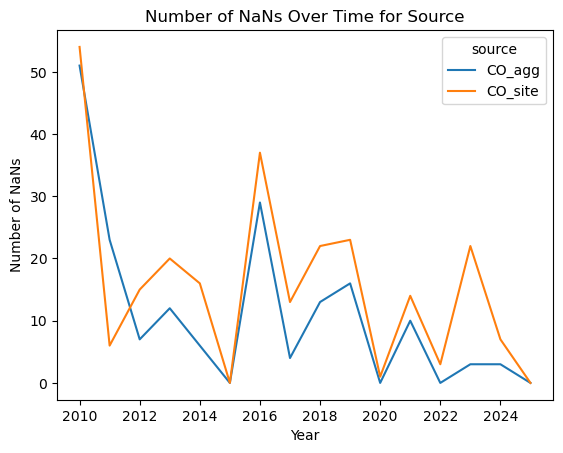

In [48]:
bnei_brak_long = daily_bnei_brak.melt(id_vars = ['date'], var_name = 'source', value_name='co')

nan_by_year = bnei_brak_long.groupby([bnei_brak_long['date'].dt.year, 
                      'source'])['co'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
					  
sns.lineplot(data = nan_by_year, x='date', y='NaN Count', hue='source')
plt.xlabel("Year")
plt.ylabel("Number of NaNs")
plt.title("Number of NaNs Over Time for Source")
plt.legend(title="source")
plt.show()

In [50]:
nan_by_year.groupby('source')['NaN Count'].sum().reset_index()

,source,NaN Count
0,CO_agg,177
1,CO_site,253


In [192]:
monthly_bnei_brak = daily_bnei_brak.groupby([
        daily_bnei_brak['date_time'].dt.year.rename('year'),
        daily_bnei_brak['date_time'].dt.month.rename('month'),
    ])[daily_bnei_brak.columns[1:]].mean().reset_index()
monthly_bnei_brak['date'] = pd.to_datetime(monthly_bnei_brak[['year','month']].assign(day=1))
monthly_bnei_brak = monthly_bnei_brak.drop(["year","month"], axis =1)

In [193]:
monthly_bnei_brak_longer = monthly_bnei_brak.melt(id_vars=['date'], var_name='data_source', value_name='co')

In [194]:
def extract_decomposition(group, period_months, value_name='co'):
    group = group.dropna(subset=[value_name])
    decomposition = seasonal_decompose(group[value_name], period=period_months, model='additive', extrapolate_trend='freq')
    group['Observed'] = decomposition.observed
    group['Trend'] = decomposition.trend
    group['Seasonal'] = decomposition.seasonal
    group['Residuals'] = decomposition.resid
    return group

In [195]:
decomposition = (
    monthly_bnei_brak_longer.set_index("data_source")
    .groupby("data_source", group_keys=False, sort=False)
    .apply(extract_decomposition, period_months=12)
    .reset_index()
)

In [201]:
def plot_spectral(df, spectral_component):
    plt.figure(figsize = (12, 6))
    sns.lineplot(data = df, x="date", y=spectral_component, hue = "data_source")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel("Year")
    plt.ylabel(spectral_component)
    plt.title("{} component of spectral decomposition for all monitoring stations".format(spectral_component))
    plt.show()

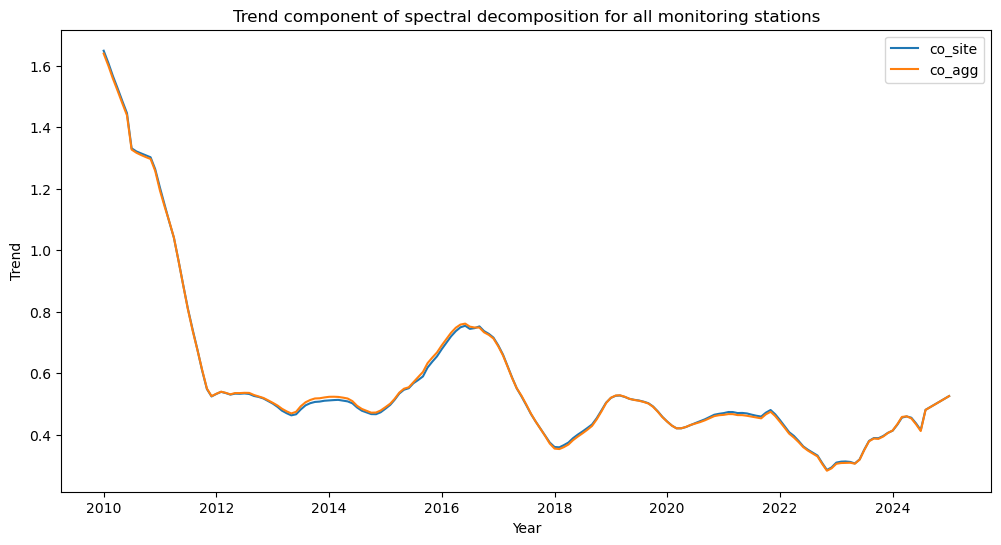

In [202]:
plot_spectral(decomposition, "Trend")

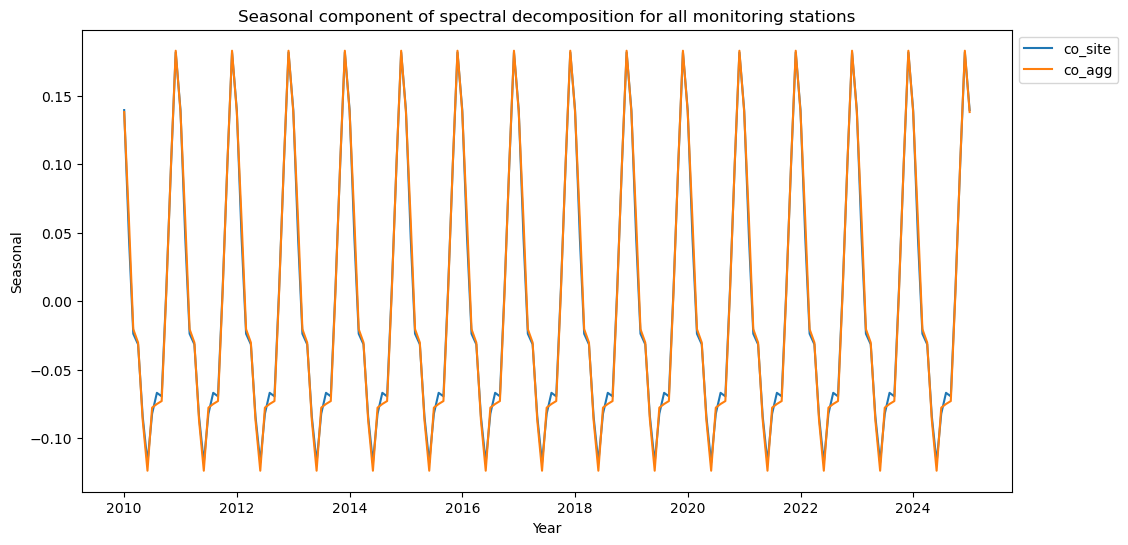

In [203]:
plot_spectral(decomposition, "Seasonal")